# **Diffusion model from scratch**
Please refer to the respective sections in the book for further details.

## **Step 1. Installing libraries**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

In [ ]:
image_size = 32
batch_size = 64
number_of_timesteps = 30
time_scale_array = 1 - np.linspace(0, 1.0, number_of_timesteps + 1)

In [ ]:
device = torch.device('cuda')

## **Step 2. Data Preprocessing**

In [ ]:
mnist_image_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=mnist_image_transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 113481358.11it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27555890.31it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 9480187.24it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3658638.13it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
index_for_7 = [i for i, (img, label) in enumerate(dataset) if label == 7]
subset_training = torch.utils.data.Subset(dataset, index_for_7)

traindata_loader = torch.utils.data.DataLoader(subset_training, batch_size=batch_size, shuffle=True, num_workers=4)

## **Step 3. Model Training**

In [ ]:
def add_stepwise_forward_noise(x_img, t_step):
    p = time_scale_array[t_step]
    q = time_scale_array[t_step + 1]

    noise = np.random.normal(size=x_img.shape)
    p = p.reshape((-1, 1, 1, 1))
    q = q.reshape((-1, 1, 1, 1))
    img_p = x_img * (1 - p) + noise * p
    img_q = x_img * (1 - q) + noise * q
    return img_p, img_q

In [ ]:
def generate_random_timesteps(num):
    return np.random.randint(0, number_of_timesteps, size=num)

In [ ]:
def display_image_grid(image):
    image = image.permute([0, 2, 3, 1])
    image = image - image.min()
    image = (image / image.max())
    return image.numpy().astype(np.float32)

def normalize_and_convert(x):
    plt.figure(figsize=(10, 10))
    imgs = display_image_grid(x)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

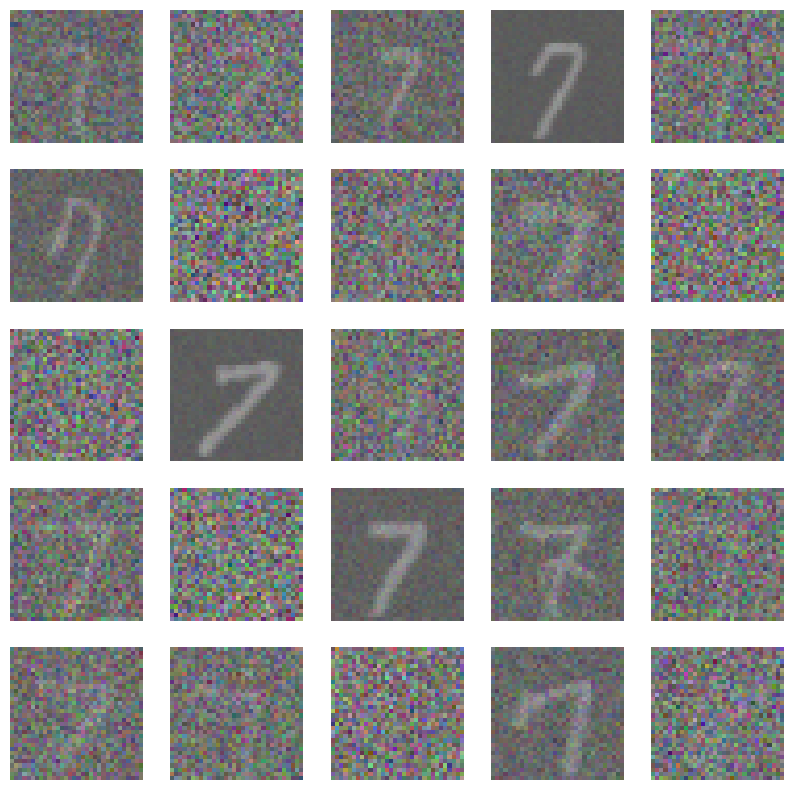

In [ ]:
rand_tsteps = generate_random_timesteps(25)
x, _ = next(iter(traindata_loader))
p, q = add_stepwise_forward_noise(x[:25], rand_tsteps)
normalize_and_convert(p)

In [ ]:
class building_block(nn.Module):
    def __init__(self, in_channels=128, size=32):
        super(building_block, self).__init__()
        self.image_feature_conv = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.timestep_dense = nn.Linear(192, 128)
        self.normalized_layer = nn.LayerNorm([128, size, size])

    def forward(self, image, timestep):
      image_feature = F.relu(self.image_feature_conv(image))
      timestep_feature = F.relu(self.timestep_dense(timestep))
      timestep_feature = timestep_feature.view(-1, 128, 1, 1)
      conditioned_image_feature = image_feature * timestep_feature
      final_output = self.output_conv(image)
      final_output = final_output + conditioned_image_feature
      final_output = F.relu(self.normalized_layer(final_output))
      return final_output

In [ ]:
class TimeStepUNet(nn.Module):
    def __init__(self):
        super(TimeStepUNet, self).__init__()

        self.timestep_processor = nn.Sequential(
            nn.Linear(1, 192),
            nn.LayerNorm([192]),
            nn.ReLU(),
        )

        self.downsample_x32 = building_block(in_channels=3, size=32)
        self.downsample_x16 = building_block(size=16)
        self.downsample_x8 = building_block(size=8)
        self.downsample_x4 = building_block(size=4)

        self.combined_feature_processor = nn.Sequential(
            nn.Linear(2240, 128),
            nn.LayerNorm([128]),
            nn.ReLU(),

            nn.Linear(128, 32 * 4 * 4),
            nn.LayerNorm([32 * 4 * 4]),
            nn.ReLU(),
        )

        self.upsample_x4 = building_block(in_channels=32 + 128, size=4)
        self.upsample_x8 = building_block(in_channels=256, size=8)
        self.upsample_x16 = building_block(in_channels=256, size=16)
        self.upsample_x32 = building_block(in_channels=256, size=32)

        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)

        self.opt = torch.optim.Adam(self.parameters(), lr=0.0008)

    def forward(self, x, x_ts):
        x_ts = self.timestep_processor(x_ts)

        blocks = [
            self.downsample_x32,
            self.downsample_x16,
            self.downsample_x8,
            self.downsample_x4,
        ]
        downsampled_layers = []
        for i, block in enumerate(blocks):
            x = block(x, x_ts)
            downsampled_layers.append(x)
            if i < len(blocks) - 1:
                x = F.max_pool2d(x, 2)

        x = x.view(-1, 128 * 4 * 4)
        x = torch.cat([x, x_ts], dim=1)
        x = self.combined_feature_processor(x)
        x = x.view(-1, 32, 4, 4)

        blocks = [
            self.upsample_x4,
            self.upsample_x8,
            self.upsample_x16,
            self.upsample_x32,
        ]

        for i, block in enumerate(blocks):
            x_left = downsampled_layers[len(blocks) - i - 1]
            x = torch.cat([x, x_left], dim=1)

            x = block(x, x_ts)
            if i < len(blocks) - 1:
                x = F.interpolate(x, scale_factor=2, mode='bilinear')

        x = self.cnn_output(x)

        return x

In [ ]:
unet_model = TimeStepUNet().to(device)

  0%|          | 0/30 [00:00<?, ?it/s]

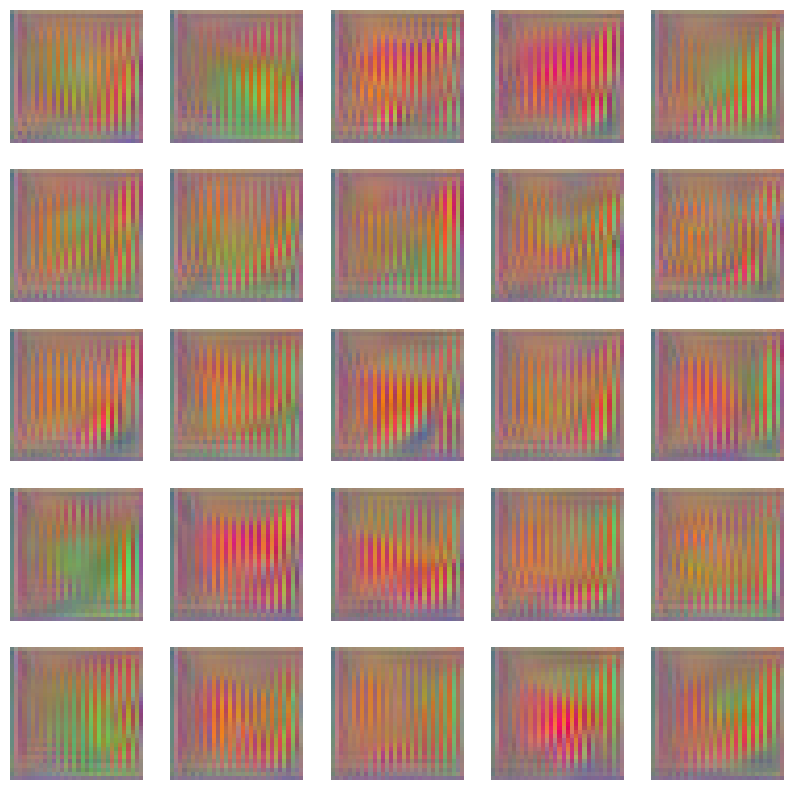

In [ ]:
def generate_images():
    generated_images = torch.randn(32, 3, image_size, image_size).to(device)
    with torch.no_grad():
        for time_step in trange(number_of_timesteps):
            current_time_step = time_step
            generated_images = unet_model(generated_images, torch.full([32, 1], current_time_step, dtype=torch.float, device=device))

    normalize_and_convert(generated_images.cpu())

generate_images()

  0%|          | 0/30 [00:00<?, ?it/s]

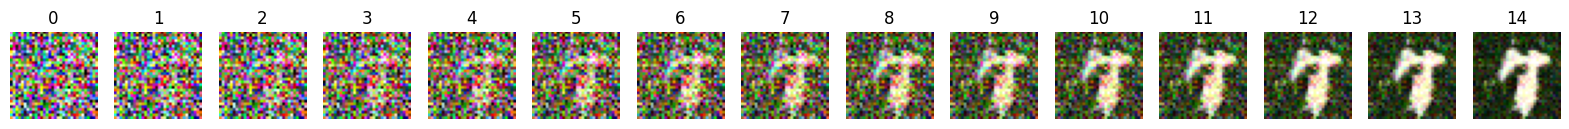

In [ ]:
def train_batch(diffusion_images):
    timestep_indices = generate_random_timesteps(len(diffusion_images))
    noisy_images, target_images = add_stepwise_forward_noise(diffusion_images, timestep_indices)

    timestep_indices = torch.from_numpy(timestep_indices).view(-1, 1).float().to(device)
    noisy_images = noisy_images.float().to(device)
    target_images = target_images.float().to(device)

    predicted_images = unet_model(noisy_images, timestep_indices)
    diffusion_loss = torch.mean(torch.abs(predicted_images - target_images))
    unet_model.opt.zero_grad()
    diffusion_loss.backward()
    unet_model.opt.step()

    return diffusion_loss.item()

In [ ]:
def execute_training_epochs(num_epochs=20):
    progress_bar = trange(num_epochs)
    total_batches = len(traindata_loader)
    for epoch in progress_bar:
        for batch_index, (batch_images, _) in enumerate(traindata_loader):
            batch_loss = train_batch(batch_images)
            progress_percentage = (batch_index / total_batches) * 100
            if batch_index % 5 == 0:
                progress_bar.set_description(f'Epoch {epoch+1}, Batch {batch_index+1}/{total_batches}, Loss: {batch_loss:.5f}, Progress: {progress_percentage:.2f}%')

In [ ]:
execute_training_epochs()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

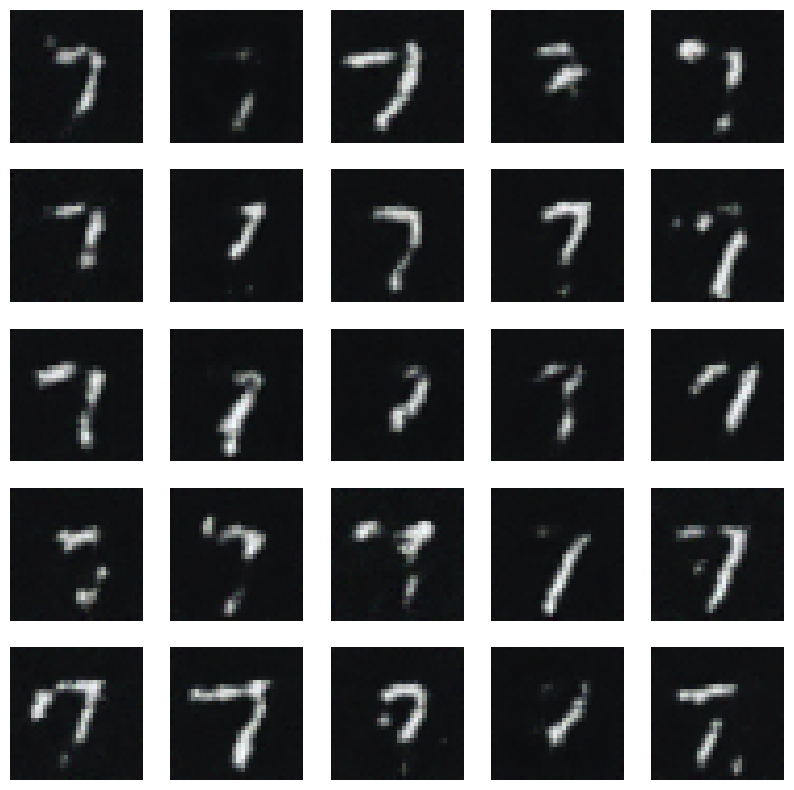

In [ ]:
generate_images()

  0%|          | 0/30 [00:00<?, ?it/s]

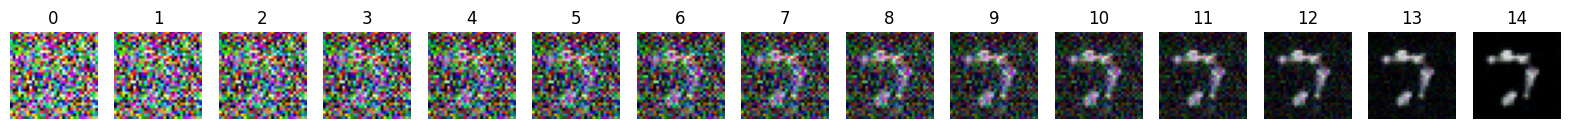

In [ ]:
def predict_step():
    xs = []
    x = torch.randn(size=(8, 3, image_size, image_size), device=device)

    with torch.no_grad():
        for i in trange(number_of_timesteps):
            t = i
            x = unet_model(x, torch.full([8, 1], t, dtype=torch.float, device=device))
            if i % 2 == 0:
                xs.append(x[0].cpu())
    xs = torch.stack(xs, dim=0)
    xs = torch.clip(xs, -1, 1)
    xs = display_image_grid(xs)

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(xs[i])
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

In [ ]:
def visualize_diffusion_steps():
    diffusion_sequence = []
    evolving_image = torch.randn(size=(8, 3, image_size, image_size), device=device)

    with torch.no_grad():
        for timestep in trange(number_of_timesteps):
            current_timestep = timestep
            evolving_image = unet_model(evolving_image, torch.full([8, 1], current_timestep, dtype=torch.float, device=device))
            if timestep % 2 == 0:
                diffusion_sequence.append(evolving_image[0].cpu())
    diffusion_sequence = torch.stack(diffusion_sequence, dim=0)
    diffusion_sequence = torch.clip(diffusion_sequence, -1, 1)
    visualized_images = display_image_grid(diffusion_sequence)

    plt.figure(figsize=(20, 2))
    for image_index in range(len(visualized_images)):
        plt.subplot(1, len(visualized_images), image_index+1)
        plt.imshow(visualized_images[image_index])
        plt.title(f'Step {image_index}')
        plt.axis('off')

  0%|          | 0/30 [00:00<?, ?it/s]

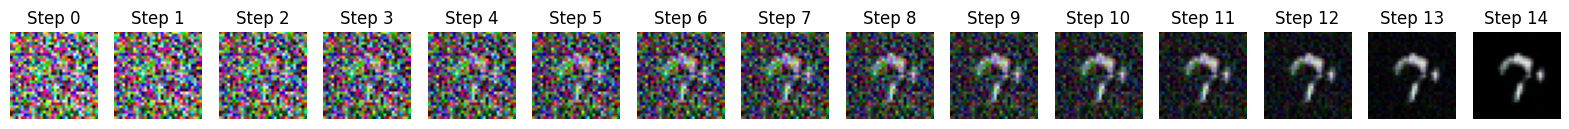

In [ ]:
visualize_diffusion_steps()